## Library

In [17]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from sklearn.neighbors import NearestNeighbors

## Load the saved pickle data

In [2]:
# # Generate random dots
# dots = np.random.rand(3, 10) * 100 # Shape ndot * ndim
#X_C_I_list.pkl
#X_C_I_DinoRing_list.pkl
with open('X_C_I_DinoRing_list.pkl', 'rb') as handle:
    X_C_I_list = pkl.load(handle)
    
X_list = X_C_I_list[0]

X = np.vstack(X_list).squeeze(axis = 2).T


X = X.T
# X is now (n, 3)

X.shape

(32268, 3)

# Apply Kernel K-Means Algorithm

In [3]:
def plot_3d(X):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.scatter3D(X[:,0],X[:,1],X[:,2])
    plt.show()
    
    pass

In [41]:
def kmeans(X,k, threshold, ismean=True):
    print('Starting K-MEANS')
    # K means on euclidean DISTANCE
    if ismean:
        mean_center = np.mean(X, axis = 0)
    else:
        mean_center = np.median(X, axis = 0)
        
    dist_vec = np.linalg.norm(X - mean_center, axis = 1)

    # Assign k clusters
    cluster_assignments = KMeans(n_clusters=k, random_state=0).fit_predict(dist_vec[:,None])
    
    X_clean_list = []
    for i in range(k):

        X_k = X[np.where(cluster_assignments == i)]

        # Keep points that have at least threshold amount of points
        if len(X_k) >= threshold:
            X_clean_list.append(X_k)

    # Rebuild new points after removing 
    X_clean = np.vstack(X_clean_list)
    print("Points lost: ", len(X) - len(X_clean))
    print("Points remaining:", len(X_clean))
    
    return X_clean

In [47]:
# mean_center = np.mean(X, axis = 0)
# dist_vec = np.linalg.norm(X - mean_center, axis = 1)
# # sns.distplot(dist_vec[np.where(dist_vec < 5)], hist=True, kde=True, color = 'darkblue')
# dist_vec.shape, X.shape

def spacial_cutoff(X, threshold, ifmean = True):
    
    if ifmean:
        mean_center = np.mean(X, axis = 0)
    else:
        mean_center = np.median(X, axis = 0)
        
    dist_vec = np.linalg.norm(X - mean_center, axis = 1)
    return X[np.where(dist_vec < threshold)]

In [48]:
def gaussian(X, ismean=True, alpha = 0.05):
    print('Starting GAUSSIAN')
    if ismean:
        mean_vec = np.mean(X, axis = 0)
    else:
        mean_vec = np.median(X, axis = 0)
        
    cov_mat = np.cov(X, rowvar = 0)

    print('FIT MULTIVARIATE GAUSSIAN')
    p = multivariate_normal.cdf(X, mean = mean_vec, cov = cov_mat)

    X_clean = X[np.where((p > alpha) & (p < (1-alpha)))]
    print("Points lost:", len(X) - len(X_clean))
    print("Points remaining:", len(X_clean))
    
    return X_clean

In [82]:
def gmm_cutoff(X, k, threshold):
    GMM = GaussianMixture(n_components=k, random_state=0).fit(X)
    score = GMM.score_samples(X)
    return X[np.where(score > threshold)]

<IPython.core.display.Javascript object>


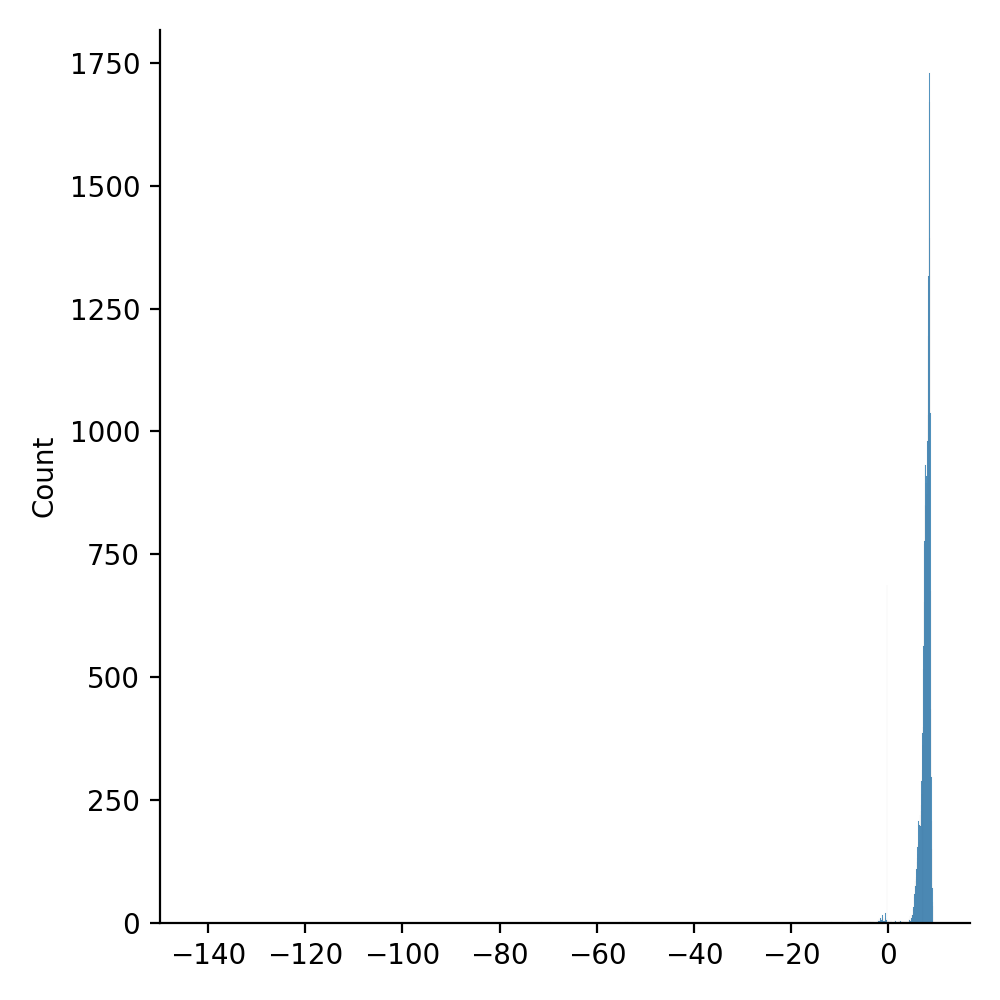

9.216603774535855

In [81]:
score = gmm_cutoff(X, 5)
sns.displot(score)
score.max()

In [49]:
def nearestn(X, n_neighbor, n_int = 1, threshold = 0.001):
    print('Starting NN')
    X_clean = X
    
    for i in range(n_int):
        print(i)
        n_before = len(X_clean)
        knc = NearestNeighbors(n_neighbors = n_neighbor)
        knc_fit = knc.fit(X_clean)
        neigh_dist, neigh_ind = knc_fit.kneighbors()
        print(min(neigh_dist),max(neigh_dist))
        X_clean = X_clean[np.where(neigh_dist < threshold)[0],:]

        n_after = len(X_clean)
        print("Points lost:", n_before - n_after)
    print("Points remaining:", len(X_clean))


    return X_clean



In [50]:
# X_clean = kmeans(X = X, k = k_kmeans, threshold = threshold_kmeans, ismean = ismean_kmeans)
# X_clean = nearestn(X = X, n_neighbor = n_neighbor, n_int = n_int, threshold = threshold_nn)
# X_clean = gaussian(X = X, ismean = ismean_gaussian)

In [51]:
# def kmeans_outlier_remover_and_plot(X, k, threshold, alpha = 0.05):
    
#     mean_center = np.mean(X, axis = 0)
#     dist_vec = np.linalg.norm(X - mean_center, axis = 1)
#     cluster_assignments = KMeans(n_clusters=k, random_state=0).fit_predict(dist_vec[:,None])
    
#     pts_lost = 0

#     X_clean_list = []
#     for i in range(k):

#         X_k = X[np.where(cluster_assignments == i)]


#         if len(X_k) >= threshold:
#             X_clean_list.append(X_k)
#         else:
#             pts_lost += len(X_k)

#     print(pts_lost)

#     X_clean = np.vstack(X_clean_list)
    
    
#     # GAUSSIAN
    
#     mean_vec = np.mean(X_clean, axis = 0)
#     # mean_vec = np.median(X, axis = 0)
#     cov_mat = np.cov(X_clean, rowvar = 0)
    
#     print('FIT MODEL')
#     p = multivariate_normal.cdf(X_clean, mean = mean_vec, cov = cov_mat)

#     print(X_clean.shape)
#     X_clean = X_clean[np.where((p > alpha) & (p < (1-alpha)))]
#     print(X_clean.shape)
    
    
#     fig = plt.figure()
#     ax = plt.axes(projection='3d')

#     ax.scatter3D(X_clean[:,0],X_clean[:,1],X_clean[:,2])
#     plt.show()
    
#     return X_clean



In [55]:
# KMEANS
k_kmeans = 5
threshold_kmeans = 10
ismean_kmeans = True

# NN
n_neighbor = 1
n_int = 1
threshold_nn = 0.005

# GAUSSIAN
ismean_gaussian = True
alpha = 0.05

In [56]:
X_clean.shape, X.shape

((137, 3), (32268, 3))

<IPython.core.display.Javascript object>


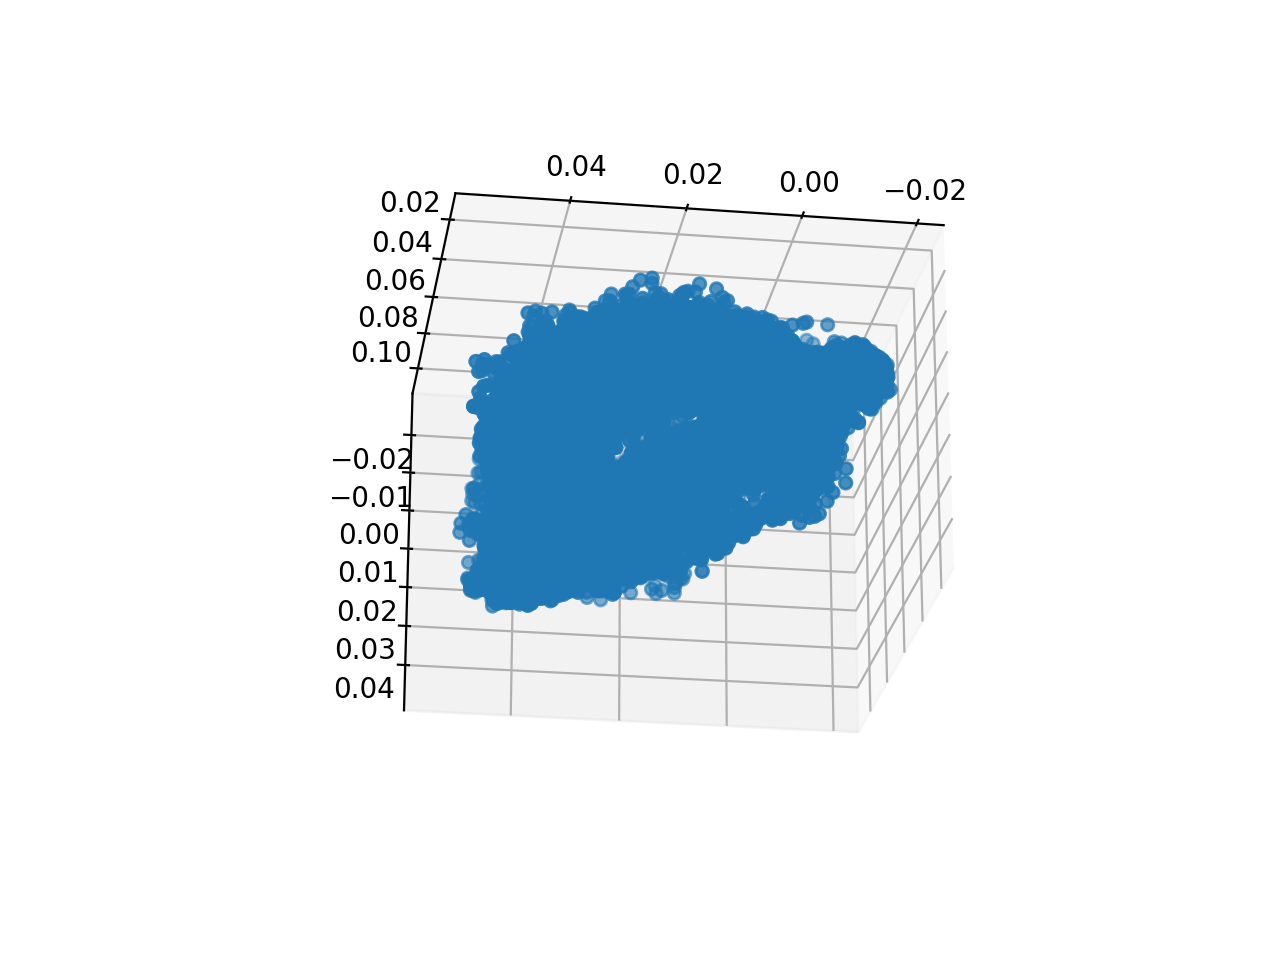

(32268, 3)

In [99]:
%matplotlib notebook

# Initial X
#     - Bunch of outliers

X_clean = spacial_cutoff(X = X, threshold = 0.05)
X_clean = gmm_cutoff(X = X_clean, k = 20, threshold = 4)
# X_clean = kmeans(X = X_clean, k = k_kmeans, threshold = 0.05, ismean = ismean_kmeans)
# X_clean = nearestn(X = X_clean, n_neighbor = n_neighbor, n_int = n_int, threshold = 0.002)
# # X_clean = gaussian(X = X_clean, ismean = False, alpha = 0.1)
# X_clean = kmeans(X = X_clean, k = 100, threshold = 100, ismean = False)
# X_clean = nearestn(X = X_clean, n_neighbor = n_neighbor, n_int = n_int, threshold = 0.01)


plot_3d(X_clean)

X.shape

In [16]:
with open('X_clean_array_4.pkl', 'wb') as handle:
    pkl.dump(X_clean, handle, protocol=pkl.HIGHEST_PROTOCOL)

